# Reducing the dimensionality of digital images
**Execution timie:** 5 minutes

## Introduction to the Case Study

**Business Context.** You are a computer security advisor with knowledge in Machine Learning from AI Integrated Services (fictitious name). This New York-based company provides Artificial Intelligence services and is looking for talent for one of its projects, real-time digits recognition.

**Business Problem.** The algorithmic techniques that the company currently uses to process handcrafted images require large data storage that the company cannot provide, so it's in the process of reducing local storage capacity to migrate data to the cloud, maximizing space optimization. In this way, all data related to digit images should be optimized in storage, losing as little content as possible.

**Data context.** The data to be processed was obtained from a large number of digital contracts, currently available in the following files: `train-images`, `train-labels`, `test-images` and `test-labels`.

## Importing the packages for data analysis

We will use three main packages: `pandas`, `numpy`, and `matplotlib`. Let's import these packages using the `import` keyword. We will rename `pandas` to `pd`, `numpy` to `np`, and `matplotlib` to `plt`, using the `as` keyword.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from MNIST import MNIST_Reader

We will read a series of grayscale digital image files representing the digits of digital contracts, separated into training and testing data. Each data set consists of 28x28 digit grayscale images, stored as serialized `numpy` arrays. We will use the `MNIST` (specifically the `MNIST_Reader`) package provided to read and load the images.

Let's now instantiate the class and read the images of the digit 7:

In [2]:
training_set, testing_set = MNIST_Reader().load_images_from_digit(digit=7)

Let's check the size of the arrays containing the images:

In [3]:
print(training_set.shape, testing_set.shape)

(28, 28, 3132) (28, 28, 3133)


As we can see, we have 3132 training images and 313 testing images, all of them with a spatial resolution (size) of 28x28 pixels. Let's now look at three randomly selected images:

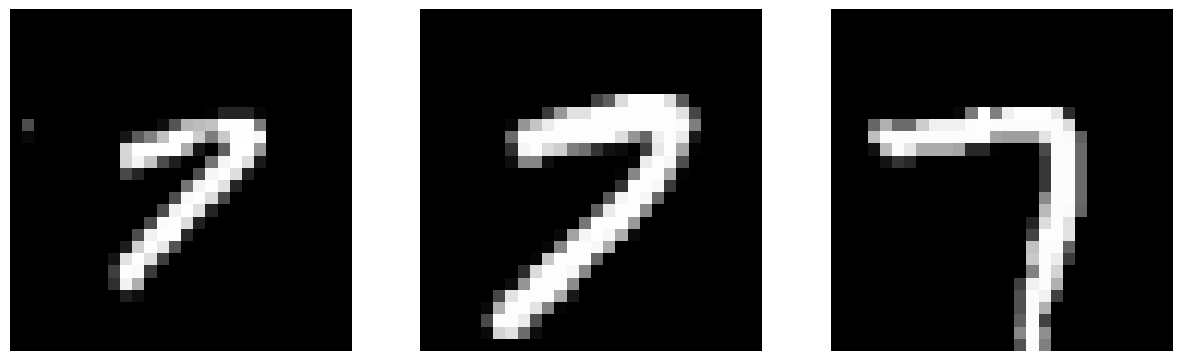

In [4]:
# Plot three images

image_indices = [1, 100, 1000]                       # Hand-picked image indices
fig, axes = plt.subplots(1,3,figsize=(15,100))       # Plottig three images in one row
plt.rcParams['image.cmap'] = 'gray'                  # Param defining grayscale images to be plotted
for idx,image_idx in enumerate(image_indices):       # Plotting the three images selected
    axes[idx].imshow(training_set[:,:,image_idx])
    axes[idx].axis('off')
plt.show()                                           # Showing the images in the plot

### Question 1
As we can see in the image examples above, the digits have different shapes. What difficulties can you identify considering that our goal is to reduce the dimensionality of the images? Add your explanation below.

**Answer:** add your explanation here

# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique based on the linear projection of the components of data by maximizing the explained variance.

To reduce dimensionality we will follow these three steps:

1. Center the data to remove the mean
2. Compute the covariance matrix Σ using the `np.cov()` function
3. Calculate the eigenvalues and eigenvectors of the covariance matrix using the `np.linalg.eigh()` function:
   - The eigenvector of the largest eigenvalue $𝜆_1$ becomes the principal component
   - The eigenvector of the 𝑘 largest eigenvalue $𝜆_𝑘$ becomes the 𝑘 component.

Let's see these steps implemented in the `pca()` function that receives as inputs (a) the data set `X` (where the rows correspond to observations and the columns to attributes), and (b) the number of components `n_components`:

In [5]:
def pca(X, n_components):
    """
    Returns the n principal components of an input data set
    Inputs:
        - X: samples data set
        - n_components: number of components to be retrieved
    Outputs:
        - X_mean: average matrix of data set X
        - comps_eigvals: eigenvalues of data set X after removing the mean
        - components: values of the n principal components of data set X
    """
        
    # Center the data by removing the mean
    X_mean = X.mean(axis=0)
    X_copy = (X - X_mean)
    
    # Compupte the covariane matrix Σ
    cov = np.cov(X_copy.T)

    # Calculate the eigenvectors and eigenvalues of matrix X through the covariance matrix
    eigvals, eigvects = np.linalg.eigh(cov)
    
    # Return eigenvectors in descending order according to the eigenvalues
    components = eigvects[:,-n_components:]
    comps_eigvals = eigvals[::-1]
        
    # Return the data mean, the eigenvalues sorted from highest to lowest and the principal components
    return X_mean, comps_eigvals, components

Let's define the training set as `X` and the testing set as `Y`:

In [6]:
# Reshaping the 28x28 images into (28*28)x1 arrays
X = np.reshape(training_set,(28*28,3132)).T
Y = np.reshape(testing_set,(28*28,3133)).T

Let's call the function that we just created to calculate the 784 (28*28) principal components to confirm that we are not losing information (we are passing the same number of components as the entire of pixels, therefore we should not lose information):

In [7]:
X_mean, eigvals, components = pca(X, n_components=784)

Now let's check what the 784 components extracted look like:

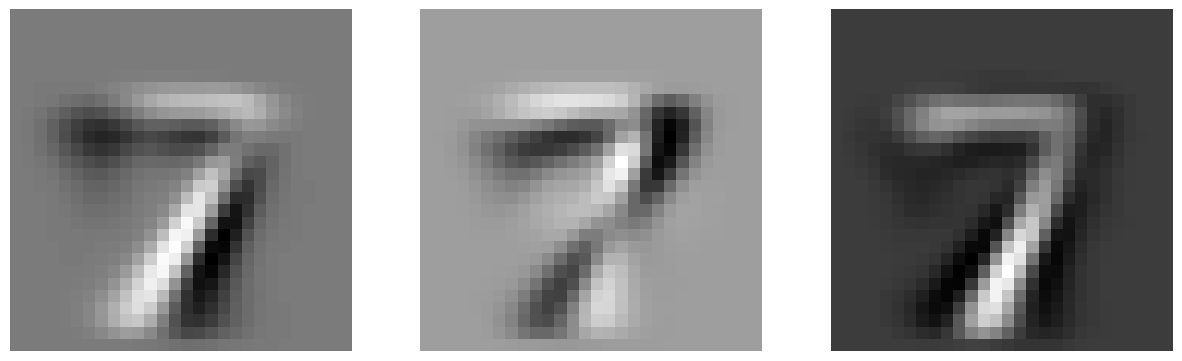

In [8]:
# Reshaping the components into 28x28 images
comp_ = np.reshape(components,(28,28,784))

# Plotting three sample images through their principal components
fig, axes = plt.subplots(1,3,figsize=(15,100))     # Plottig three images in one row
plt.rcParams['image.cmap'] = 'gray'                # Param defining grayscale images to be plotted
for i in range(-1, -4, -1):                        # Plotting the last three set of components 
    axes[-i-1].imshow(comp_[:,:,i])                # (i will go from -1 to -3 inclusive)
    axes[-i-1].axis('off')
plt.show()                                         # Showing the images in the plot

As we can see, the images seem to have been distorted a little. This is because **the main components of the images are not in the same dimensional space** as the original ones.

To return images with spatial dimensionality equivalent to the original ones and on the same dimensional space, the **linear projection** of the reduced components can be calculated in the following way:

In [9]:
def pca_project(X,X_mean,components):
    """
    Resturns the projection of the principal components in the dimensional space of original data
    Inputs:
        - X: original data set
        - X_mean: average matrix of data set X
        - components: n principal components sorted in decreasing order w.r.t. the eigenvalues
    Outputs:
        - reconst_vector: rconstructed vector in the same dimensional space as X
    """
    # Compute the linear projection of the components
    projs = (X - X_mean)@components
    
    # Compute projection expansion coefficients
    reconstruction = projs@components.T
    
    # Return projected data around the mean
    reconst_vector = X_mean + reconstruction
    return reconst_vector

This might sound a bit abstract and mathematical, so let's see an example using the same 784 components calculated in the step above:

In [10]:
# Calculate the linear projection of the components
X_projected = pca_project(X,X_mean,components)

Now let's plot the projection of the first image of the training set on which we had calculated the principal 784 components and compare it with the original image - they should look identical since we grabbed all 784 components available:

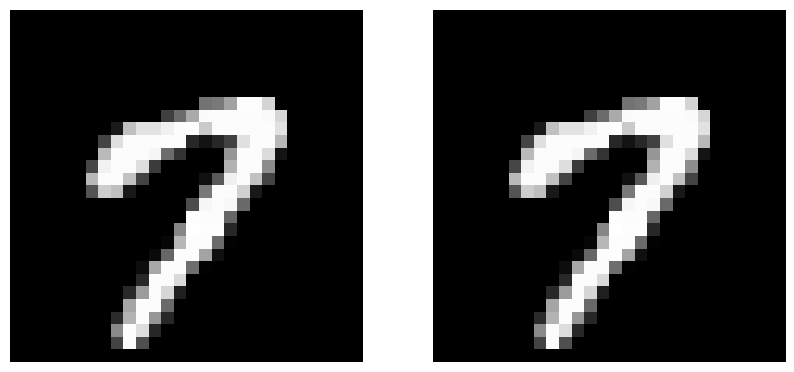

In [11]:
# Reshape the training images so that they are 28x28
X_ = np.reshape(X_projected.T,(28,28,3132))

# Plot the original image and the projected image with the calculated 784 components
fig, axes = plt.subplots(1,2,figsize=(10,100))    # Plottig two images in one row
plt.rcParams['image.cmap'] = 'gray'               # Param defining grayscale images to be plotted
axes[0].imshow(training_set[:,:,0])               # Plotting one of the original training images
axes[1].imshow(X_[:,:,0])                         # Plotting the reconstructed image with the principal components calculated
axes[0].axis('off')
axes[1].axis('off')
plt.show()                                        # Showing the images in the plot

Visually we can notice that both images, the original and the reconstructed one based on the projected principal components, are considerably similar. To verify that we did not loose any information and that both are identical, we subtract the second image from the first. If the images are identical, we should obtain a black image, meaning no differences on a pixel-per-pixel basis:

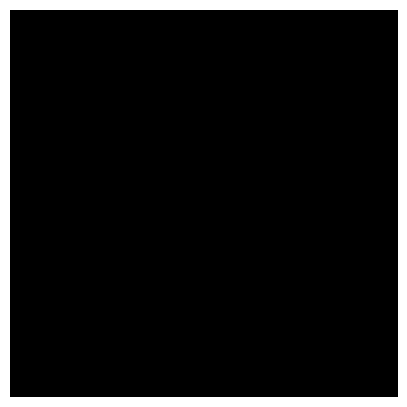

In [12]:
# Plot the difference between the original image and the reconstructed one based on the principal components
fig, axes = plt.subplots(1,1,figsize=(5,100))                      # Plottig one image in the row
plt.rcParams['image.cmap'] = 'gray'                                # Param defining grayscale images to be plotted
negligible_thresh = 10**(-12)                                      # Threshold from which the difference is negligible
axes.imshow(training_set[:,:,0]-X_[:,:,0]>negligible_thresh)       # Calculating the difference and testing the threshold
axes.axis('off')
plt.show()                                                         # Showing the images in the plot

As we can notice, the image is completely black, which means that the original image and the reconstructed image are exactly the same pixel per pixel.

Let's look at an example of a 75% dimensionality reduction (keeping 25% of the dimensions). We are going to reduce the dimensionality of the images from 784 (28x28) dimensions to 196 (14x14) dimensions:

In [13]:
# Calculate the first of 196 (14x14) principal components
X_mean, eigvals, components = pca(X,n_components=196)

# Calculate the components projection
X_projected = pca_project(X,X_mean,components)

Now let's plot the projection of the first image of the training set, this time with 196 components (instead of 784) and compare it with the original image:

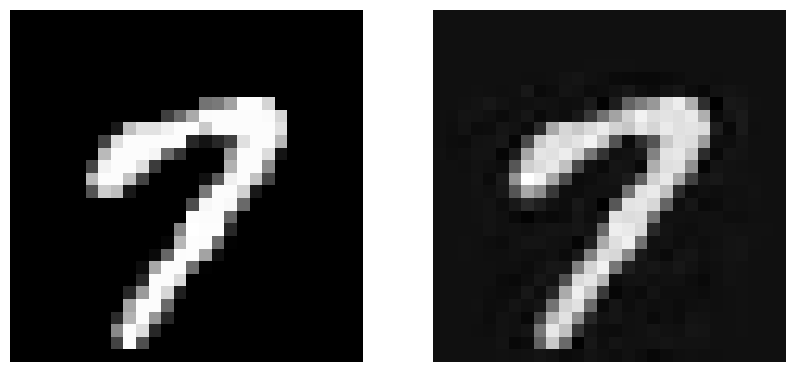

In [14]:
# Reshape the training images so that they are 28x28
X_ = np.reshape(X_projected.T,(28,28,3132))

# Plot the original image and the projected image with the calculated 196 components
fig, axes = plt.subplots(1,2,figsize=(10,100))    # Plottig two images in one row
plt.rcParams['image.cmap'] = 'gray'               # Param defining grayscale images to be plotted
axes[0].imshow(training_set[:,:,0])               # Plotting one of the original training images
axes[1].imshow(X_[:,:,0])                         # Plotting the reconstructed image with the principal components calculated
axes[0].axis('off')
axes[1].axis('off')
plt.show()                                        # Showing the images in the plot

### Quation 2
Are these two images the same? What differences can we observe and what are these differences due to? Add your explanation below.

**Answer:** add your explanation here.

We are going to generalize the algorithms above to iterate over the image dimensions, in such a way that we reduce progressively the output dimensions from 28x28 (784 dimensions) to 4x4 (16 dimensions):

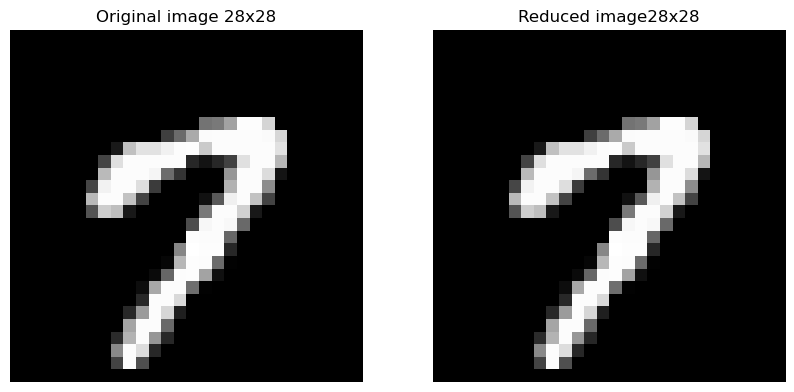

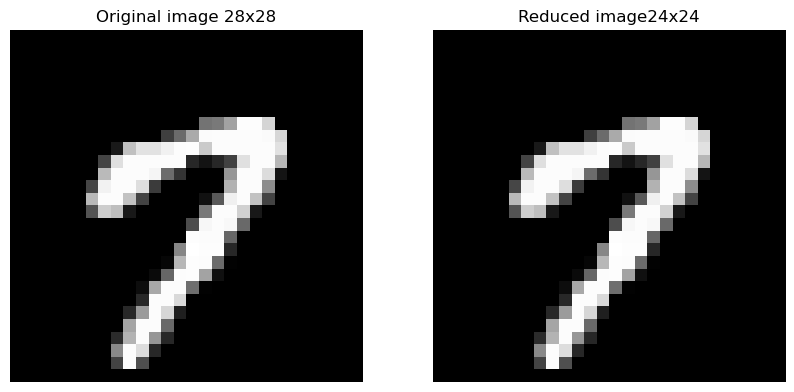

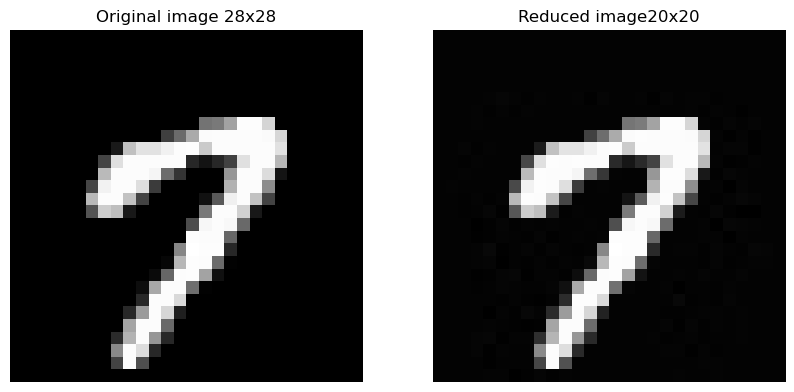

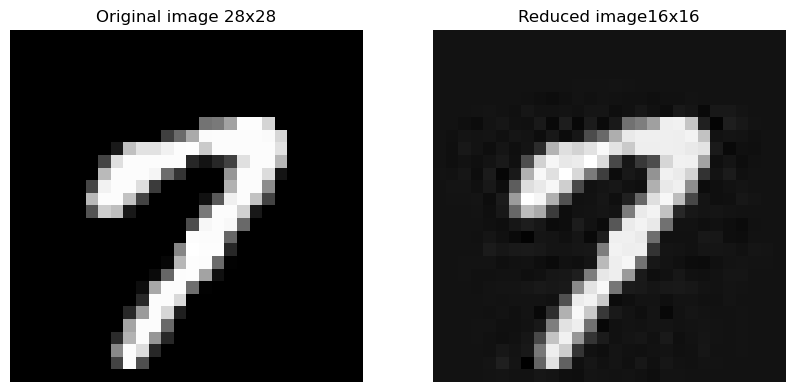

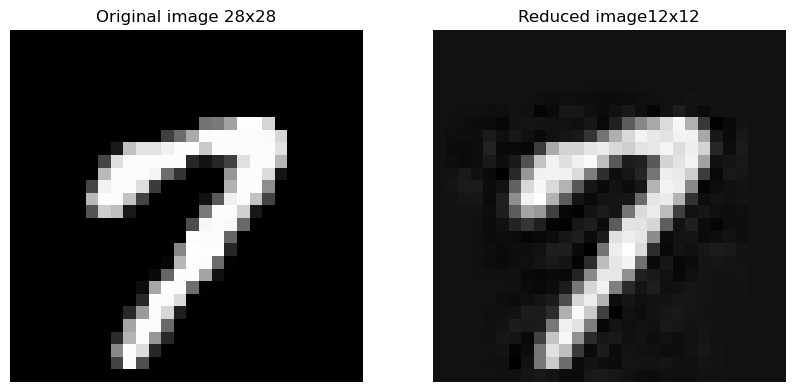

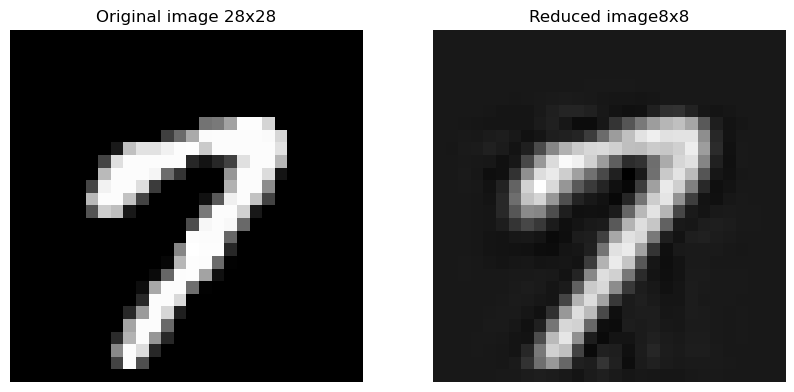

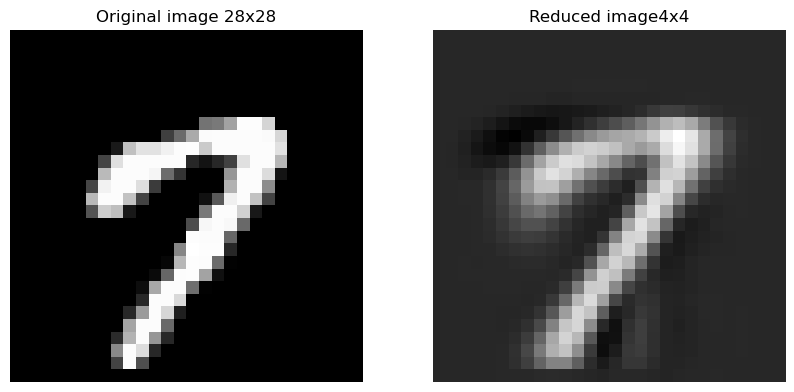

In [15]:
# Loop that iterates over the dimensions from 4x4 to 28x28 in decreasing order
for n_comps in range(28, 1, -4):
    # Calculate the first n_comps*n_comps principal components
    X_mean, eigvals, components = pca(X,n_components=n_comps**2)

    # Calculate the components projections
    X_projected = pca_project(X,X_mean,components)

    # Reshape the training images so that they are 28x28
    X_ = np.reshape(X_projected.T,(28,28,3132))

    # Plot the original image and the projected image with the calculated nxn components
    fig, axes = plt.subplots(1,2,figsize=(10,100))                     # Plottig two images in one row
    plt.rcParams['image.cmap'] = 'gray'                                # Param defining grayscale images to be plotted
    axes[0].imshow(training_set[:,:,0])                                # Plotting one of the original training images
    axes[1].imshow(X_[:,:,0])                                          # Plotting the reconstructed image
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title('Original image 28x28')                         # Setting the titles for both images in the row
    axes[1].set_title('Reduced image{}x{}'.format(n_comps,n_comps))
    plt.show()                                                        # Showing the images in the plot

### Question 3
What pattern are the images following when they are reduced in dimensionality and projected onto the dimensional space of the original images? To answer this question you may focus first on the following:
- What differences can you identify when comparing the original image against the reduced one?
- What is causing these noticeable differences?
- In which step are the most differences appreciated?
- Of what nature are the differences that can be seen?

Add your explanation below.

**Answer:** add your explanation here.

### Question 4
What pros and cons can you identify from the dimensionality reduction task done so far? Add your explanation below.

**Answer:** add your explanation here.

Since we have identified how to reduce the dimensionality of digital images and have seen what effects the reduction can cause, we are going to quantitatively measure this effect through the percentage of explained variance of the calculated components. The explained variance of a component ${PC}_k$ can be calculated as:

$$explained \; variance \; {PC}_k = \left( \frac{eigenvalue \; {PC}_k}{\sum_{i=1}^{p} eigenvalue \; {PC}_i} \right)$$

Let's see an example with the first 196 principal components extracted above:

In [16]:
# Define the number of principal components (n)
n_components = 196

# Calculate the first n principal components
X_mean, eigvals, components = pca(X, n_components=n_components)

# Calculate the explained variance of the first principal component (position 0)
print(eigvals[0]/eigvals.sum())

0.1626121920649325


In other words, the first component (which has the highest eigenvalue) explains 16% of the variance in the data set. Let's now see what the variance of the first five components looks like:

In [17]:
# Calculate the explained variance of the first five principal components individually
print(eigvals[:5]/eigvals.sum())

[0.16261219 0.11122374 0.08595537 0.05626025 0.04535021]


We can see that the second component explains 11%, the third 8.6%, the fourth 5.6% and the fifth 4.5%. The more we add components, the less variance in the data they will explain because they have lower eigenvalues. Now let's add up how much the first five components explain in total:

In [18]:
# Calculate the explained variance of the first five principal components in total
print((eigvals[:5]/eigvals.sum()).sum())

0.46140175822202


The first five principal components explain 46% of the variance, almost half of the variance of the data! Let's see how the accumulated explained variance varies when we increase the number of principal components calculated:

In [19]:
# Iteration range (over each of the components form 1 to 784)
range_comps = range(1, 28*28+1)

# Creating an empty list to add the cumulative explained variance by number of components
variance = []

# Iterating over the components with the given range
for n_comps in range_comps:
    X_mean, eigvals, components = pca(X, n_components=n_comps)  # Calculating the first n_comps principal components
    variance.append((eigvals[:n_comps]/eigvals.sum()).sum())    # Calculating the explained variance

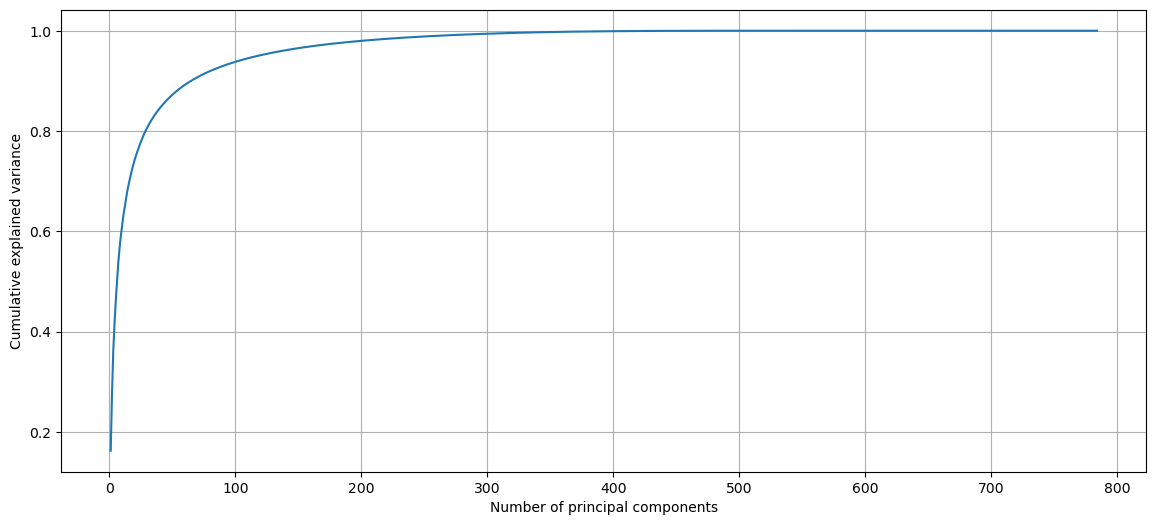

In [20]:
# Plotting the explained variance in terms of the number of principal components
plt.figure(figsize=(14,6))
plt.plot(range_comps, variance)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

Accumulated explained variance from the 300th principal components is approximately 100% and the gain from further increasing components is completely marginal. Let's see what happens with the first 100 components:

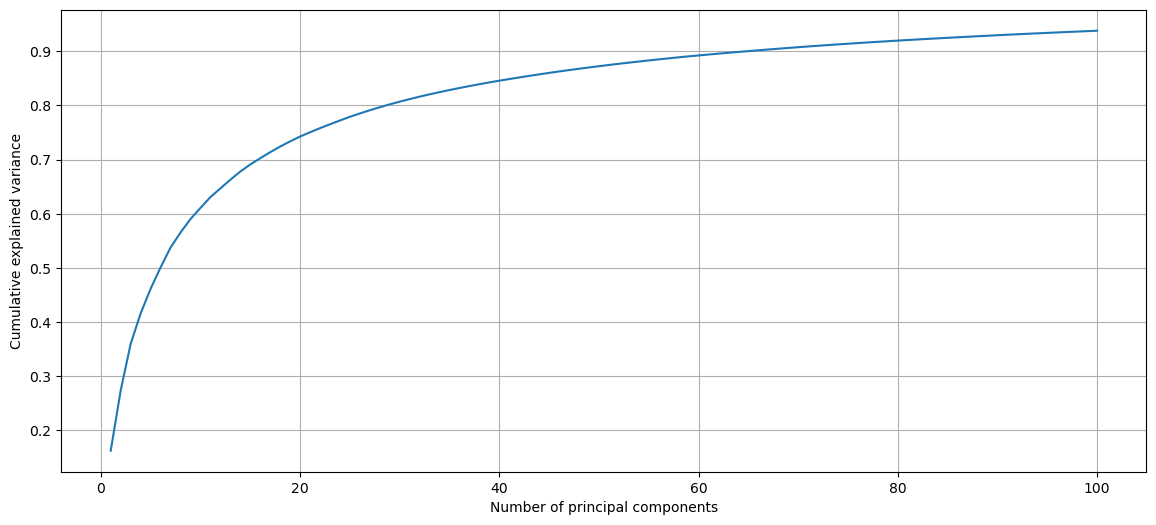

In [21]:
# Plotting the explained variance of the first 100 principal components
plt.figure(figsize=(14,6))
plt.plot(range_comps[:100], variance[:100])
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

### Question 5

Write some observations from the graph above. Are there any opportunities dimensionality reduction can exploit to reduce the storage and computational resources needed to process the images given?

**Answer:** add your explanation here.

## Lessons learned

- We learned how to work with dimensionality reduction algorithms such as PCA with a complete implementation of the decomposition into principal components, the projection of the components in the original dimensional space and the calculation of the accumulated explained variance.
- We learned how to apply dimensionality reduction on digital images.